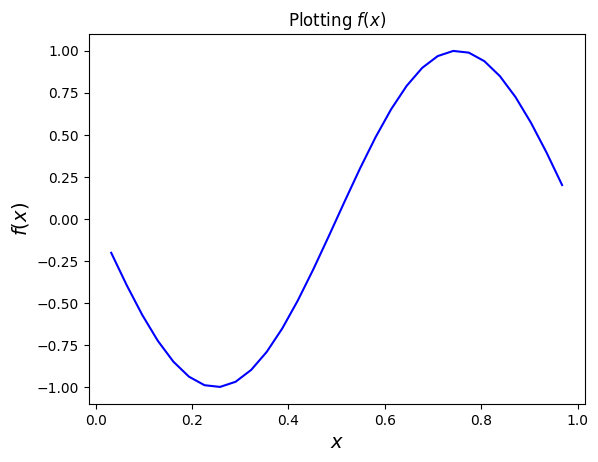

Tiempo para la eliminacion de Gauss en segundos:  0.0015642000071238726


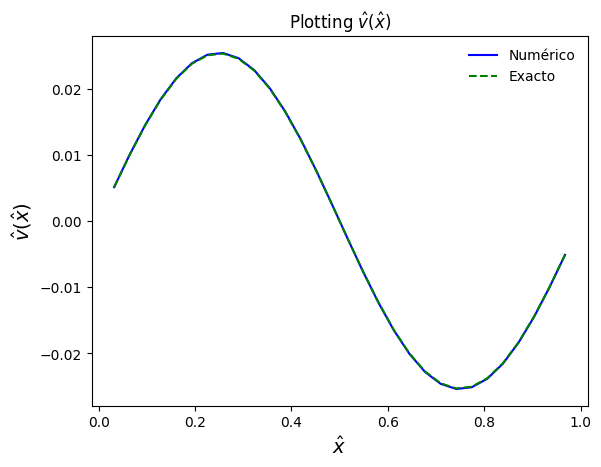

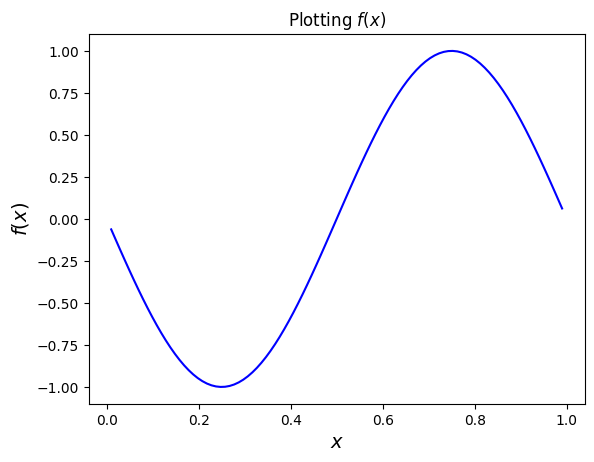

Tiempo para la eliminacion de Gauss en segundos:  0.015234100006637163


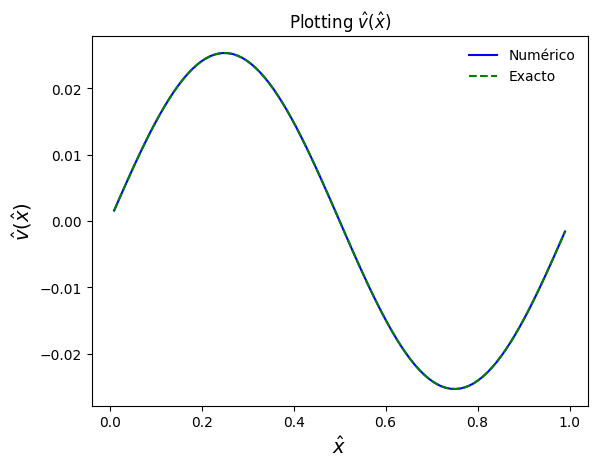

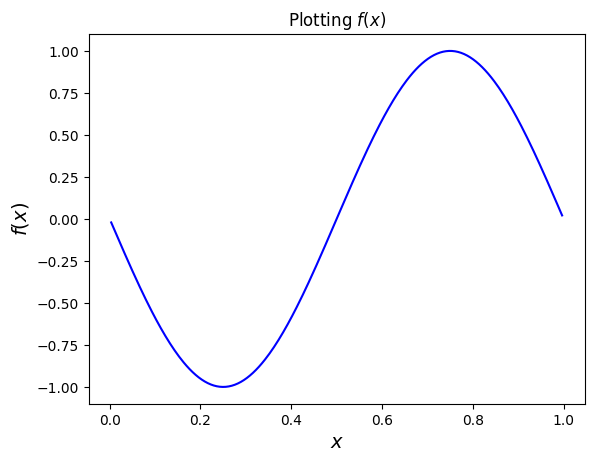

Tiempo para la eliminacion de Gauss en segundos:  0.17016680000233464


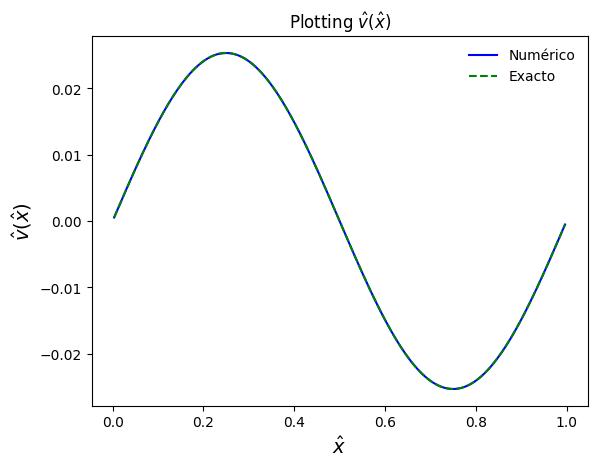

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

N = [30, 100, 300]
D = 0.02
for n in range(3):
    h = D / (N[n] + 1)

    x = np.linspace(h, D-h, N[n]) # voy cambiando aca
    f = -np.sin(2 * np.pi * x)  
    fh2 = f * h**2  
    vt = np.sin(2 * np.pi * x) / (4 * np.pi**2)

    # Graficamos la funcion f(x)
    plt.plot(x, f, color='blue')
    plt.title('Plotting $f(x)$')
    plt.xlabel("$x$", fontsize=14)
    plt.ylabel("$f(x)$", fontsize=14)
    plt.show()

    # Construimos la matriz tridiagonal A
    A = np.zeros([N[n], N[n]])
    for i in range(N[n]):
        for j in range(N[n]):
            if i == j:
                A[i, j] = -2.
            elif abs(i - j) == 1:
                A[i, j] = 1.

    # Initializamos el vector solucion v
    v = np.zeros(N[n])

    # eliminacion de Gauss
    start = time.perf_counter()
    for i in range(N[n]):  # i is the column index
        p1 = A[i, i]
        for j in range(N[n]):  # j is the pivot row index
            if j > i:
                p2 = A[j, i]
                fh2[j] -= p2 * fh2[i] / p1
                A[j,:] -= p2 * A[i,:] / p1           
    #            for k in range(N[n]):
    #                A[j, k] = A[j, k] - p2 * A[i, k] / p1

    end = time.perf_counter()
    print('Tiempo para la eliminacion de Gauss en segundos: ', end - start)

    # sustitucion
    for i in range(N[n] - 1, -1, -1):
        suma = np.dot(A[i, i + 1:], v[i + 1:])
        v[i] = (fh2[i] - suma) / A[i, i]

    # Graficamos la solucion v(x)
    plt.plot(x, v, color='blue', label='Numérico')
    plt.plot(x,vt,color='green',linestyle='dashed', label='Exacto')
    plt.title('Plotting $\hat{v}(\hat{x})$')
    plt.xlabel("$\hat{x}$", fontsize=14)
    plt.ylabel("$\hat{v}(\hat{x})$", fontsize=14)
    plt.legend(loc='upper right', frameon=False)
    plt.show()